In [1]:
from nnsight import LanguageModel
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch as t
from task_patching_utils import *
import sys
sys.path.append("/root/dictionary_learning/")
from dictionary import AutoEncoder

# Model Name
model_name = "EleutherAI/pythia-70m-deduped"
device = t.device("cuda" if t.cuda.is_available() else "cpu")

# module_name
layer = 5
module_name = f"gpt_neox.layers.{layer}"
# module_name = f"gpt_neox.layers.{layer}.mlp"
# module_name = f"gpt_neox.layers.{layer}.attention"

# Attribution Patching
top_k_features = 100

# Task
task = "gender"
num_datapoints = 32 # Could go higher if we can batch attrib_effect()

# Overall Dataset
dataset_name = "stas/openwebtext-10k"
ctx_length = 256
batch_size = 6
total_batches = 10 # We calculate KL overall over this many batches
print(f"Calculating KL overall on {ctx_length*batch_size*total_batches} tokens")

# Patching
tracer_kwargs = {'validate' : False, 'scan' : False}

#SAEs
# sae_locations = [f"/root/dictionary_learning/dictionaries/pythia-70m-deduped/mlp_out_layer{layer}/{training_ind}_32768/ae.pt" for training_ind in ["1", "5", "10"]]
sae_locations = [f"/root/dictionary_learning/dictionaries/pythia-70m-deduped/resid_out_layer{layer}/{training_ind}_32768/ae.pt" for training_ind in ["5", "10"]]
# sae_locations = [f"/root/dictionary_learning/dictionaries/pythia-70m-deduped/attn_out_layer{layer}/{training_ind}_32768/ae.pt" for training_ind in ["5", "10"]]
# sae_locations = ["random"] + [f"/root/dictionary_learning/dictionaries/pythia-70m-deduped/resid_out_layer{layer}/{training_ind}_32768/ae.pt" for training_ind in ["5", "10"]]

/root/dictionary_learning/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Calculating KL overall on 15360 tokens


# Outline
- Load model
- Load Dataset (Task & Overall)
- loop over SAEs
- Plot

In [2]:
# Load Model
model = LanguageModel(
    model_name,
    device_map = device,
    dispatch = True,
)
model_hh = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Get module by it's name
attributes = module_name.split('.')
module = model
for attr in attributes:
    module = getattr(module, attr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
from task_patching_utils import *
# Overall Dataset
dataset_name = "stas/openwebtext-10k"
ctx_length = 256
batch_size = 6
total_batches = 10 # We calculate KL overall over this many batches
print(f"Calculating KL overall on {ctx_length*batch_size*total_batches} tokens")

# load dataset
overall_dataset_dl = load_overall_dataset(dataset_name, tokenizer, ctx_length, batch_size, shuffle=False)

Calculating KL overall on 15360 tokens


/root/dictionary_learning/logan/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for stas/openwebtext-10k contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/stas/openwebtext-10k
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.
/root/dictionary_learning/logan/lib/python3.10/site-packages/datasets/download/download_manager.py:400: FutureWarning: 'num_proc' was deprecated in version 2.6.2 and will be removed in 3.0.0. Pass `DownloadConfig(num_proc=<num_proc>)` to the initializer instead.
  warnings.warn(
Map (num_proc=6): 100%|██████████| 10000/10000 [00:16<00:00, 599.79 examples/s] 


In [4]:
from torch.utils.data import DataLoader
# load task dataset
# TODO: We might want to loop over tasks as well in the inner loop of looping SAEs
task_function = get_task_function(task)

clean_text, patched_text, clean_labels, patched_labels = task_function(num_datapoints)
tokenized_clean_text, target_token_position_clean, token_clean_labels = tokenize_task_data(clean_text, clean_labels, tokenizer)
tokenized_patched_text, target_token_position_patched, token_patched_labels = tokenize_task_data(patched_text, patched_labels, tokenizer)

tokenized_clean_text_dl = DataLoader(tokenized_clean_text, batch_size=batch_size, shuffle=False)
tokenized_patched_text_dl = DataLoader(tokenized_patched_text, batch_size=batch_size, shuffle=False)

In [5]:
clean_text

[' Ken left the documents on the table before',
 ' When the alarm rang, Erik was already prepared because',
 ' Mike played the guitar, and everyone listened until',
 ' During the party, Noah sang beautifully until',
 ' After the lecture, Juan quickly left the room as',
 ' On the trip, Jimmy took many photos before',
 ' After finishing the book, Adam felt quite emotional as',
 ' After the lecture, Henry quickly left the room as',
 ' During the party, Noah sang beautifully until',
 ' In the meeting, John gave an opinion and then',
 ' In the meeting, Lucas gave an opinion and then',
 ' On the trip, Carlos took many photos before',
 ' Next to the window, Erik set up the workspace and soon',
 ' Adam finished the presentation, and everyone applauded as',
 ' When the alarm rang, Richard was already prepared because',
 ' Noah wrote a new blog post, and right after publishing it',
 ' Juan called their friends, and soon',
 ' Noah left the documents on the table before',
 ' Once the game was over

In [6]:
# def overall_kl(model, kl_data_dataloader, ae, features, activation_name, total_batches=10):
#     kl_losses = t.zeros(len(features))
#     with t.no_grad():
#         for feature_ind, feature in enumerate(tqdm(features)):
#             hook_function = partial(sae_ablation, features=[feature.item()], sae=ae)
#             for batch_ind, batch in enumerate(kl_data_dataloader):
#                 if(batch_ind >= total_batches):
#                     break
#                 with Trace(model, activation_name, edit_output=hook_function) as ret:
#                     edited_logits = model(batch.to(model.device)).logits
#                 original_logits = model(batch.to(model.device)).logits
#                 return edited_logits, original_logits
#                 kl_div_value = kl_div(original_logits, edited_logits, log_target=True, reduction="batchmean")
#                 kl_losses[feature_ind] += kl_div_value.item()
#         kl_losses /= total_batches
#     return kl_losses
# sae = AutoEncoder.from_pretrained(sae_location).to(device)
# o_log, e_log = overall_kl(model_hh, overall_dataset_dl, sae, top_features, module_name, total_batches=total_batches)

In [7]:
# batch_mean_both_log = kl_div(o_log.log_softmax(dim=-1), e_log.log_softmax(dim=-1), log_target=True, reduction="none")
# # batch_mean_both_log = kl_div(o_log.log_softmax(dim=-1), e_log.log_softmax(dim=-1), log_target=True, reduction="sum")
# batch_mean_one_log = kl_div(o_log.log_softmax(-1), e_log, reduction="none")
# print(f"Batch Mean KL Divergence (both log): {batch_mean_both_log}")
# print(f"Batch Mean KL Divergence (one log): {batch_mean_one_log}")

In [8]:
# batch_mean_both_log.sum(-1).mean(), batch_mean_both_log.mean(), kl_div(o_log.log_softmax(dim=-1), e_log.log_softmax(dim=-1), log_target=True, reduction="sum")


In [9]:
# # this is the same example in wiki
# P = t.Tensor([0.36, 0.48, 0.16])
# Q = t.Tensor([0.333, 0.333, 0.333])

# (P * (P / Q).log()).sum(), kl_div(Q.log(), P, None, None, 'sum'), kl_div(Q.log(), P, None, None, reduction="none")

In [10]:
features_per_sae = []
task_kl_per_sae = []
overall_kl_per_sae = []

# def overall_kl(model, kl_data_dataloader, ae, features, activation_name, total_batches=10):
#     kl_losses = t.zeros(len(features))
#     with t.no_grad():
#         for feature_ind, feature in enumerate(tqdm(features)):
#             hook_function = partial(sae_ablation, features=[feature.item()], sae=ae)
#             for batch_ind, batch in enumerate(kl_data_dataloader):
#                 if(batch_ind >= total_batches):
#                     break
#                 with Trace(model, activation_name, edit_output=hook_function) as ret:
#                     edited_logits = model(batch.to(model.device)).logits.log_softmax(dim=-1)
#                 original_logits = model(batch.to(model.device)).logits.log_softmax(dim=-1)
#                 kl_div_value = kl_div(
#                     original_logits, 
#                     edited_logits, 
#                     log_target=True, 
#                     reduction="none",
#                 ).sum(dim=-1)
#                 # find location of max_kl_div
#                 max_kl_val, max_kl_ind = kl_div_value.reshape(-1).topk(3)
#                 # now decode the token at that position
#                 batch_reshaped = batch.reshape(-1)
#                 # print(max_kl_ind)
#                 # print(batch_reshaped)
#                 max_kl_tokens = tokenizer.batch_decode(batch_reshaped[max_kl_ind.cpu()])
#                 # print(f"Max KL Divergence: {max_kl_val}")
#                 # print(f"Max KL Tokens: {max_kl_tokens}")
#                 kl_losses[feature_ind] += kl_div_value.mean().item()
#                 # print(f"Max KL Divergence: {max_kl}")
#                 # kl_losses[feature_ind] += kl_div_value.item()
#         kl_losses /= total_batches
#     return kl_losses

# Load saes
for sae_location in tqdm(sae_locations):
    if(sae_location == "random"):
        # d_model = model_hh.config.d_model
        d_model = 512
        num_features = 32768
        sae = AutoEncoder(d_model, num_features).to(device)
    else:
        sae = AutoEncoder.from_pretrained(sae_location).to(device)
    #TODO: below is awkard for our purpose. Maybe refactor
    dictionaries = {}
    submodule_names = {}
    submodule_names[module] = module_name
    dictionaries[module] = sae
    submodules = [module]

    # Patching
    # TODO: patching effect doesn't take into account the correct positions given padding
    # Add token positions to metric_kwargs
    effects, _, _, total_effect = patching_effect(
        clean_text,
        patched_text,
        model,
        submodules = submodules,
        dictionaries = dictionaries,
        tracer_kwargs=tracer_kwargs,
        metric_fn = logit_diff_metric,
        metric_kwargs={'clean_answers': token_clean_labels, 'patch_answers': token_patched_labels},
    )
    for submodule in submodules:
        effects[submodule] = effects[submodule].act
    module_effect = effects[module]
    # Sum over all datapoints & positions
    top_val, top_features = module_effect.sum(0).sum(0).topk(top_k_features)
    # top_threshold = 0.9
    # top_thresh_effect_features = ((top_val.cumsum(0) / top_val.sum()) > top_threshold).nonzero()[0][0].item()
    # top_features = top_features[:top_thresh_effect_features]
    # top_features = top_features[:3]
    # print("90\% of effect is in top", top_thresh_effect_features, "features")
    kl_task_losses = task_kl(model_hh, tokenized_clean_text_dl,  target_token_position_clean,  sae, top_features, module_name)
    kl_overall_losses = overall_kl(model_hh, overall_dataset_dl, sae, top_features, module_name, total_batches=total_batches)
    
    features_per_sae.append(top_features)
    task_kl_per_sae.append(kl_task_losses)
    overall_kl_per_sae.append(kl_overall_losses)

    # Save to file
    # Create folder okay
    import os
    folder = f"results/{model_name}/{module_name}/"
    os.makedirs(folder, exist_ok=True)
    if(sae_location == "random"):
        sae_name = "random"
    else:
        sae_name = sae_location.split("/")[-2]
    file_name_prefix = f"{sae_name}_{sae_name}"
    t.save(top_features, f"{folder}{file_name_prefix}_features.pt")
    t.save(kl_task_losses, f"{folder}{file_name_prefix}_task_kl.pt")
    t.save(kl_overall_losses, f"{folder}{file_name_prefix}_overall_kl.pt")

100%|██████████| 2/2 [01:50<00:00, 55.20s/it]


In [11]:
top_thresh_effect_features = ((top_val.cumsum(0) / top_val.sum()) > top_threshold).nonzero()[0][0].item()
top_thresh_effect_features

NameError: name 'top_threshold' is not defined

In [ ]:
val = module_effect.sum(0).sum(0).topk(100).values
top_threshold = 0.9
top_thresh_effect_features = ((val.cumsum(0) / val.sum()) > top_threshold).nonzero()[0][0].item()
top_thresh_effect_features

25

In [ ]:
top_features

tensor([26074, 10643, 14088], device='cuda:0')

/tmp/ipykernel_186489/2612172964.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min_lim, max_lim)
/tmp/ipykernel_186489/2612172964.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(min_lim, max_lim)


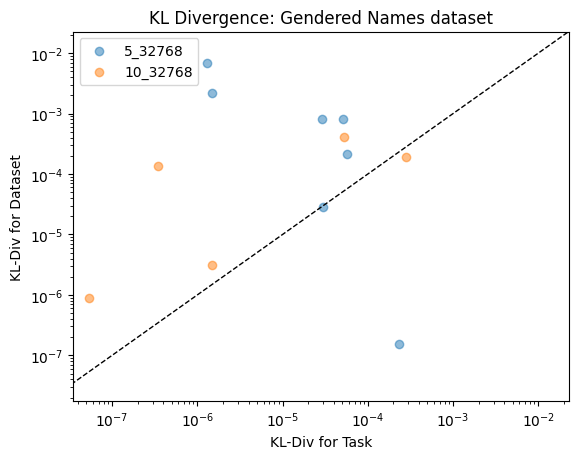

In [12]:
import numpy as np
from matplotlib import pyplot as plt
for sae_ind, (kl_task_losses, kl_overall_losses) in enumerate(zip(task_kl_per_sae, overall_kl_per_sae)):
    if(sae_locations[sae_ind] == "random"):
        sae_name = "random"
    else:
        sae_name = sae_locations[sae_ind].split("/")[-2]
    plt.scatter(kl_task_losses, kl_overall_losses, label=f"{sae_name}", alpha=0.5)
# plt.scatter(att_pathing_pos_kl_task, att_pathing_pos_kl_overall, label=f"Top {top_k} Pos-3 Features", alpha=0.5, color="cyan")
# plt.scatter(all_kl_task_losses, all_kl_overall_losses, label="All Features", alpha=0.5, color="blue")
plt.xlabel("KL-Div for Task")
plt.ylabel("KL-Div for Dataset")
plt.title("KL Divergence: Gendered Names dataset")
# log both axes
# Log scale for both axes
plt.yscale("log")
plt.xscale("log")

# Determine the global min and max for setting identical and suitable axes limits
# all_data = np.concatenate([att_patching_kl_task_losses, att_patching_kl_overall_losses, att_pathing_pos_kl_task, att_pathing_pos_kl_overall])
min= 1000
max= -1
for sae_ind, (kl_task_losses, kl_overall_losses) in enumerate(zip(task_kl_per_sae, overall_kl_per_sae)):
    min = np.min([min, kl_task_losses.min(), kl_overall_losses.min()])
    max = np.max([max, kl_task_losses.max(), kl_overall_losses.max()])
all_data = np.concatenate([kl_task_losses, kl_overall_losses])

# min_lim = np.min(all_data)
# max_lim = np.max(all_data)
min_lim = min
max_lim = max

# Set the same limits for both axes
plt.xlim(min_lim, max_lim)
plt.ylim(min_lim, max_lim)

# Plot a diagonal line
plt.plot([min_lim, max_lim], [min_lim, max_lim], 'k--', linewidth=1)  # 'k--' is a black dotted line

plt.legend()
plt.show()

In [13]:
indices_top = []
for task_kl, top_f in zip(task_kl_per_sae, features_per_sae):
    val, ind = task_kl.topk(3)
    print(val)
    print(top_f[ind].tolist())
    indices_top.append(top_f[ind])

tensor([2.3247e-04, 5.7674e-05, 5.0611e-05])
[31759, 5640, 27955]
tensor([2.8260e-04, 5.2241e-05, 1.4822e-06])
[6171, 23141, 17303]


In [34]:
saes = []
for sae_location in tqdm(sae_locations):
    sae = AutoEncoder.from_pretrained(sae_location)
    saes.append(sae)


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


In [56]:
# with t.no_grad():
f_ind = 23141
f_vec = saes[1].decoder.weight.data[:, f_ind]

logit_lens = f_vec@model_hh.embed_out.weight.data.cpu().T
val, ind = logit_lens.log_softmax(dim=-1).topk(20)
# decode ind w/ tokenizer
tokenizer.batch_decode(ind)

[' his',
 ' him',
 ' he',
 ' Jimmy',
 ' Bobby',
 ' Eddie',
 ' Danny',
 ' her',
 ' himself',
 ' someone',
 ' everyone',
 ' Tommy',
 ' Harry',
 ' Billy',
 ' Roger',
 ' Dick',
 ' Detective',
 ' Oliver',
 ' Jack',
 ' Walter']

In [ ]:
# sae_5 = saes[1]
sae_5 = saes[0]
sae_10 = saes[1]
# ind_5 = indices_top[1]
ind_5 = indices_top[0]
ind_10 = indices_top[1]
sae_5_f = sae_5.decoder.weight.data[:, ind_5.cpu()] # shape 512, 2
sae_10_f = sae_10.decoder.weight.data[:, ind_10.cpu()]
# multiply both together to get a 2x2 cos sim (they are both normed already )
cos_sim = sae_5_f.T @ sae_10_f
cos_sim

tensor([[0.9046, 0.2002, 0.6884],
        [0.3471, 0.5057, 0.4131],
        [0.4177, 0.5547, 0.5127]])

In [ ]:
# sae_5 = saes[1]
sae_5 = saes[1]
sae_10 = saes[2]
# ind_5 = indices_top[1]
ind_5 = indices_top[1]
ind_10 = indices_top[2]
sae_5_f = sae_5.decoder.weight.data[:, ind_5.cpu()] # shape 512, 2
sae_10_f = sae_10.decoder.weight.data[:, ind_10.cpu()]
# multiply both together to get a 2x2 cos sim (they are both normed already )
cos_sim = sae_5_f.T @ sae_10_f
cos_sim

IndexError: list index out of range

#TODO: next
1. Grab top features
2. ablation & KL for task & overall
3. Save data in lists & file
4. Plot data